In [317]:
import torch
import pandas as pd
import os
from torchvision import models, transforms
from sklearn.neighbors import NearestNeighbors
from PIL import Image
import numpy as np
from csv import writer
import random

In [318]:
#random 
with open('ratings.csv','a',newline='') as fd:
    x=[]
    for i in range(1000):
        x.append(random.random())
    for i in x:
        writer(fd).writerow([i])
        

In [319]:
extracted_features = torch.load("extracted_features.pt")
user_preferance  = pd.read_csv('ratings.csv')
print(extracted_features.shape)
extracted_features=extracted_features[0:len(user_preferance)]
print(user_preferance.shape)
print(extracted_features.shape)
user_preferance = np.array(user_preferance)

torch.Size([15987, 2048])
(2999, 1)
torch.Size([2999, 2048])


C:\Users\vzhen\AppData\Local\Temp\ipykernel_15304\644064111.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  extracted_features = torch.load("extracted_features.pt")


In [320]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
resnet50 = models.resnet50(weights=None)

resnet50 = torch.nn.Sequential(*list(resnet50.children())[:-1])

resnet50.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [321]:
def get_features(image_path):
    img = Image.open(image_path).convert('RGB')
    img = transform(img).unsqueeze(0) 
    with torch.no_grad():
        features = resnet50(img)
    return features.flatten().numpy()

In [322]:
image_folder = "Pictures"
new_features = []
new_images = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png'))]
for i in new_images:
    features = get_features(i)
    new_features.append(features)

In [323]:
print(len(new_features))
new_features_np = np.array(new_features)
print(new_features_np.shape)

36
(36, 2048)


In [324]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
extracted_features = scaler.fit_transform(extracted_features)
new_features_np = scaler.transform(new_features_np)

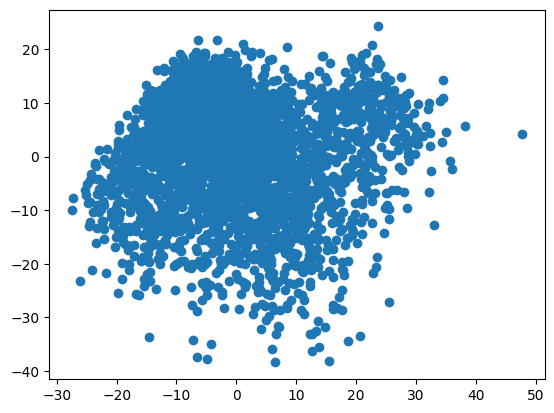

In [325]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(extracted_features)
plt.scatter(reduced_features[:, 0], reduced_features[:, 1])
plt.show()

In [326]:

model  = NearestNeighbors(n_neighbors=10)
model.fit(extracted_features)


NearestNeighbors(n_neighbors=10)

In [327]:
distances , indexes = model.kneighbors(new_features)
recommended = [] 
print(indexes[:5])
for i, path in enumerate(new_images):
    
    r = user_preferance[indexes[i]]
    a = np.mean(r)
    recommended.append((path,a))

[[2279 1020 1643  765 1320  623  599  402  943 1161]
 [2279 1020 1643  765 1320  623  599  402  943 1161]
 [2279 1020 1643  765 1320  623  599  402  943 1161]
 [2279 1020  765 1643 1320  623  599  402  943 1161]
 [2279 1020  765 1643 1320  623  599  402  943 1161]]


In [328]:
for img, avg_pref in recommended:
    print(f"Image: {img}, Recommended Preference: {avg_pref:.2f}")

Image: Pictures\file0$19.90.jpg, Recommended Preference: 0.51
Image: Pictures\file1$14.90.jpg, Recommended Preference: 0.51
Image: Pictures\file10$19.90.jpg, Recommended Preference: 0.51
Image: Pictures\file11$14.90.jpg, Recommended Preference: 0.51
Image: Pictures\file12$19.90.jpg, Recommended Preference: 0.51
Image: Pictures\file13$49.90.jpg, Recommended Preference: 0.51
Image: Pictures\file14$14.90.jpg, Recommended Preference: 0.51
Image: Pictures\file15$39.90.jpg, Recommended Preference: 0.51
Image: Pictures\file16$69.90.jpg, Recommended Preference: 0.51
Image: Pictures\file17$29.90.jpg, Recommended Preference: 0.51
Image: Pictures\file18$24.90.jpg, Recommended Preference: 0.51
Image: Pictures\file19$19.90.jpg, Recommended Preference: 0.51
Image: Pictures\file2$19.90.jpg, Recommended Preference: 0.51
Image: Pictures\file20$19.90.jpg, Recommended Preference: 0.51
Image: Pictures\file21$14.90.jpg, Recommended Preference: 0.51
Image: Pictures\file22$14.90.jpg, Recommended Preference: 